In [1]:
import math
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import polars as pl
import seaborn as sns
import tqdm.auto as tqdm
from torch import nn

In [2]:
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [3]:
from src import kernels
from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS, CIFAR10CNN
from src.models.utils import HistoryCallback, make_pooling_function
from src import load_data

In [30]:
import importlib

# from src.kernels import quadratic as quad_kernels
import src.models.simple_lenet
import src.load_data
import src.models.utils
import src.kernels.quadratic
import pytorch_semifield_conv.cuda_select

importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
importlib.reload(src.kernels.utils)
importlib.reload(pytorch_semifield_conv.cuda_select)
importlib.reload(pytorch_semifield_conv.unfold_broadcast)
importlib.reload(src.models.utils)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS
from src import load_data

# kernels = importlib.reload(kernels)
# convolutions = importlib.reload(convolutions)

In [4]:
k_mnist = load_data.k_mnist()
k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [5]:
fashion = load_data.fashion_mnist()
fashion

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [6]:
cifar10 = load_data.cifar10()
cifar10

Dataset(x_train=torch.Size([50000, 3, 32, 32]), x_test=torch.Size([10000, 3, 32, 32]), y_train=torch.Size([50000]), y_test=torch.Size([10000]))

In [32]:
k = kernels.QuadraticKernelSpectral2D(1, 10, 3, {"var": "ss-iso", "theta": "uniform"})
k

QuadraticKernelSpectral2D(
  1, 10, kernel_size=3
  (covs): LearnedSpectral2D(1, 10)
)

In [13]:
LeNet.fit_many(k_mnist, epochs=50, batch_size=1024, lr=0.004, pool_fn=make_pooling_function("aniso", 27, closing=True),
               count=5, init={"var": "ss-iso", "theta": "spin"}).scores

<function make_pooling_function.<locals>.pooling_fn at 0x7ac2fa108ae0>:{'var': 'ss-iso', 'theta': 'spin'}:   0…

KeyboardInterrupt: 

In [20]:
CIFAR10CNN.fit_many(cifar10, batch_size=1024, lr=0.004, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"},
                    count=2, epochs=200)

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/2 [00:00<?, ?run/s]

KeyboardInterrupt: 

In [16]:
cifar10

Dataset(x_train=torch.Size([50000, 3, 32, 32]), x_test=torch.Size([10000, 3, 32, 32]), y_train=torch.Size([50000]), y_test=torch.Size([10000]))

In [228]:
# from collections import defaultdict
#
#
# class InspectScales(keras.callbacks.Callback):
#     store_targets = {
#         kernels.QuadraticKernelIso2D: ("log_stds",),
#         kernels.utils.LearnedSpectral2D: ("log_stds", "thetas"),
#     }
#
#     def __init__(self, store: dict[str, list[np.ndarray] | np.ndarray], per_batch: bool = False):
#         super().__init__()
#         self.mod_counter = 0
#         self.store = store
#         self.per_batch = per_batch
#
#     def on_epoch_end(self, epoch, logs=None):
#         if not self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def on_train_batch_end(self, batch, logs=None):
#         if self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def recurse_mod(self, mod: torch.nn.Module):
#         for child in mod.children():
#             cls = type(child)
#             if cls not in self.store_targets:
#                 self.recurse_mod(child)
#                 continue
#
#             num, self.mod_counter = self.mod_counter, self.mod_counter + 1
#             targets = self.store_targets[cls]
#             for target in targets:
#                 val = getattr(child, target).squeeze().numpy(force=True)
#                 self.store.setdefault(f"{num}.{target}", []).append(val)
#
#     def on_train_end(self, logs=None):
#         for name, vals in self.store.items():
#             self.store[name] = np.stack(vals)

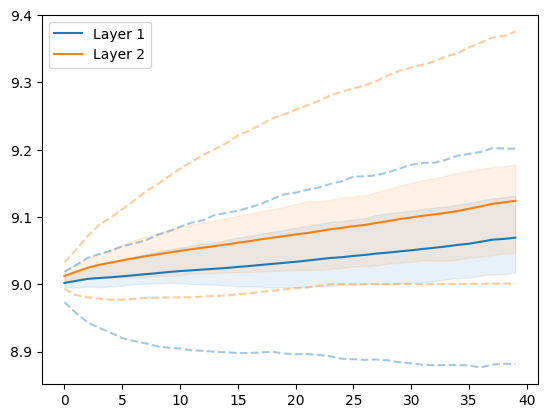

In [265]:
def plot_ci(vals: np.ndarray, ax: plt.Axes = None, label: str = ""):
    assert len(vals.shape) == 2, "Cannot plot multiple val types"
    if ax is None:
        _, ax = plt.subplots()

    q0, q1, q3, q4 = np.quantile(vals, [0, 0.25, 0.75, 1], axis=1)
    colour = ax.plot(vals.mean(axis=1), label=label)[0].get_color()
    ax.plot(q0, color=colour, linestyle="dashed", alpha=0.4)
    ax.plot(q4, color=colour, linestyle="dashed", alpha=0.4)
    ax.fill_between(range(len(vals)), q1, q3, color=colour, alpha=0.1)


_, test_ax = plt.subplots()
plot_ci(scales["0.log_stds"][..., 0], ax=test_ax, label="Layer 1")
# plot_ci(scales['0.thetas'], ax=test_ax, label="Layer 1")
plot_ci(scales["1.log_stds"][..., 0], ax=test_ax, label="Layer 2")
# plot_ci(scales['1.thetas'], ax=test_ax, label="Layer 2")
plt.legend()

In [241]:
d[0].get_color()

'#1f77b4'

In [9]:
kernels.QuadraticKernelIso2D(1, 1, 5, init=3.7)()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<ViewBackward0>)

In [11]:
# importlib.reload(src.kernels.utils)
# importlib.reload(src.kernels.quadratic)
# importlib.reload(src.kernels)
k2 = kernels.QuadraticKernelSpectral2D(1, 1, 5, init=3.7)
k3 = kernels.QuadraticKernelCholesky2D(1, 1, 5, init=3.7)
k2()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<MulBackward0>)

In [186]:
k2.covs.cov()

tensor([[[[3.0000, 0.0000],
          [0.0000, 3.0000]]]], grad_fn=<LinalgInvExBackward0>)

In [13]:
if "res" not in globals():
    res = {}
res = res

In [139]:
importlib.reload(src.models.trainer)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS
from src import load_data

# pool_fn = 'iso-5'
for pool_fn in tqdm.tqdm(EXAMPLE_POOLING_FUNCTIONS, desc="Pooling types", unit="trial"):
    res[pool_fn] = LeNet.fit_many(k_mnist, pool_fn=pool_fn, init="uniform", batch_size=1024, epochs=30)

Pooling types:   0%|          | 0/10 [00:00<?, ?trial/s]

standard-2:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

In [254]:
for size in tqdm.tqdm((3, 5, 7), desc="Aniso sizes", unit="trial"):
    res[f"aniso-{size}-spin"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="spin", batch_size=1024,
                                               epochs=30, lr=0.004)
    res[f"aniso-{size}-uiso"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="uniform-iso", batch_size=1024,
                                               epochs=30, lr=0.004)

Aniso sizes:   0%|          | 0/3 [00:00<?, ?trial/s]

aniso-3:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

dict_keys(['iso-5', 'lr=0.001', 'lr=0.0016681005372000592', 'lr=0.0027825594022071257', 'lr=0.004641588833612777', 'lr=0.007742636826811269', 'lr=0.01291549665014884', 'lr=0.021544346900318832', 'lr=0.03593813663804626', 'lr=0.05994842503189409', 'lr=0.1', 'standard-2', 'standard-3', 'standard-5', 'standard-7', 'iso-3', 'iso-7', 'aniso-3', 'aniso-5', 'aniso-7'])

In [255]:
res_sort = {k: res[k] for k in sorted(res) if 'lr=' not in k}
pl.DataFrame(res_sort).write_parquet(".data/res_100ep_extra_aniso.pq")

In [144]:
res_sort

{'aniso-3': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╡
 │ 0.9555 ┆ 0.92128  ┆ 0.970297 ┆ 0.955436 │
 │ 0.9566 ┆ 0.922686 ┆ 0.969546 ┆ 0.956549 │
 │ 0.9564 ┆ 0.924319 ┆ 0.969576 ┆ 0.956358 │
 │ 0.9569 ┆ 0.924395 ┆ 0.975634 ┆ 0.956841 │
 │ 0.9601 ┆ 0.931853 ┆ 0.976143 ┆ 0.960066 │
 │ …      ┆ …        ┆ …        ┆ …        │
 │ 0.9573 ┆ 0.918429 ┆ 0.97265  ┆ 0.95725  │
 │ 0.9592 ┆ 0.932653 ┆ 0.972678 ┆ 0.959158 │
 │ 0.9527 ┆ 0.923935 ┆ 0.966315 ┆ 0.952673 │
 │ 0.9585 ┆ 0.925115 ┆ 0.973619 ┆ 0.958414 │
 │ 0.9577 ┆ 0.92331  ┆ 0.971717 ┆ 0.95767  │
 └────────┴──────────┴──────────┴──────────┘,
 'aniso-5': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │


In [ ]:
def ren(n: str) -> str:
    if n.count("-") == 1:
        return n + "-uni"
    return n


pl.scan_parquet(".data/res1.pq").rename(ren).sink_parquet(".data/res2.pq")

(0.94, 0.97)

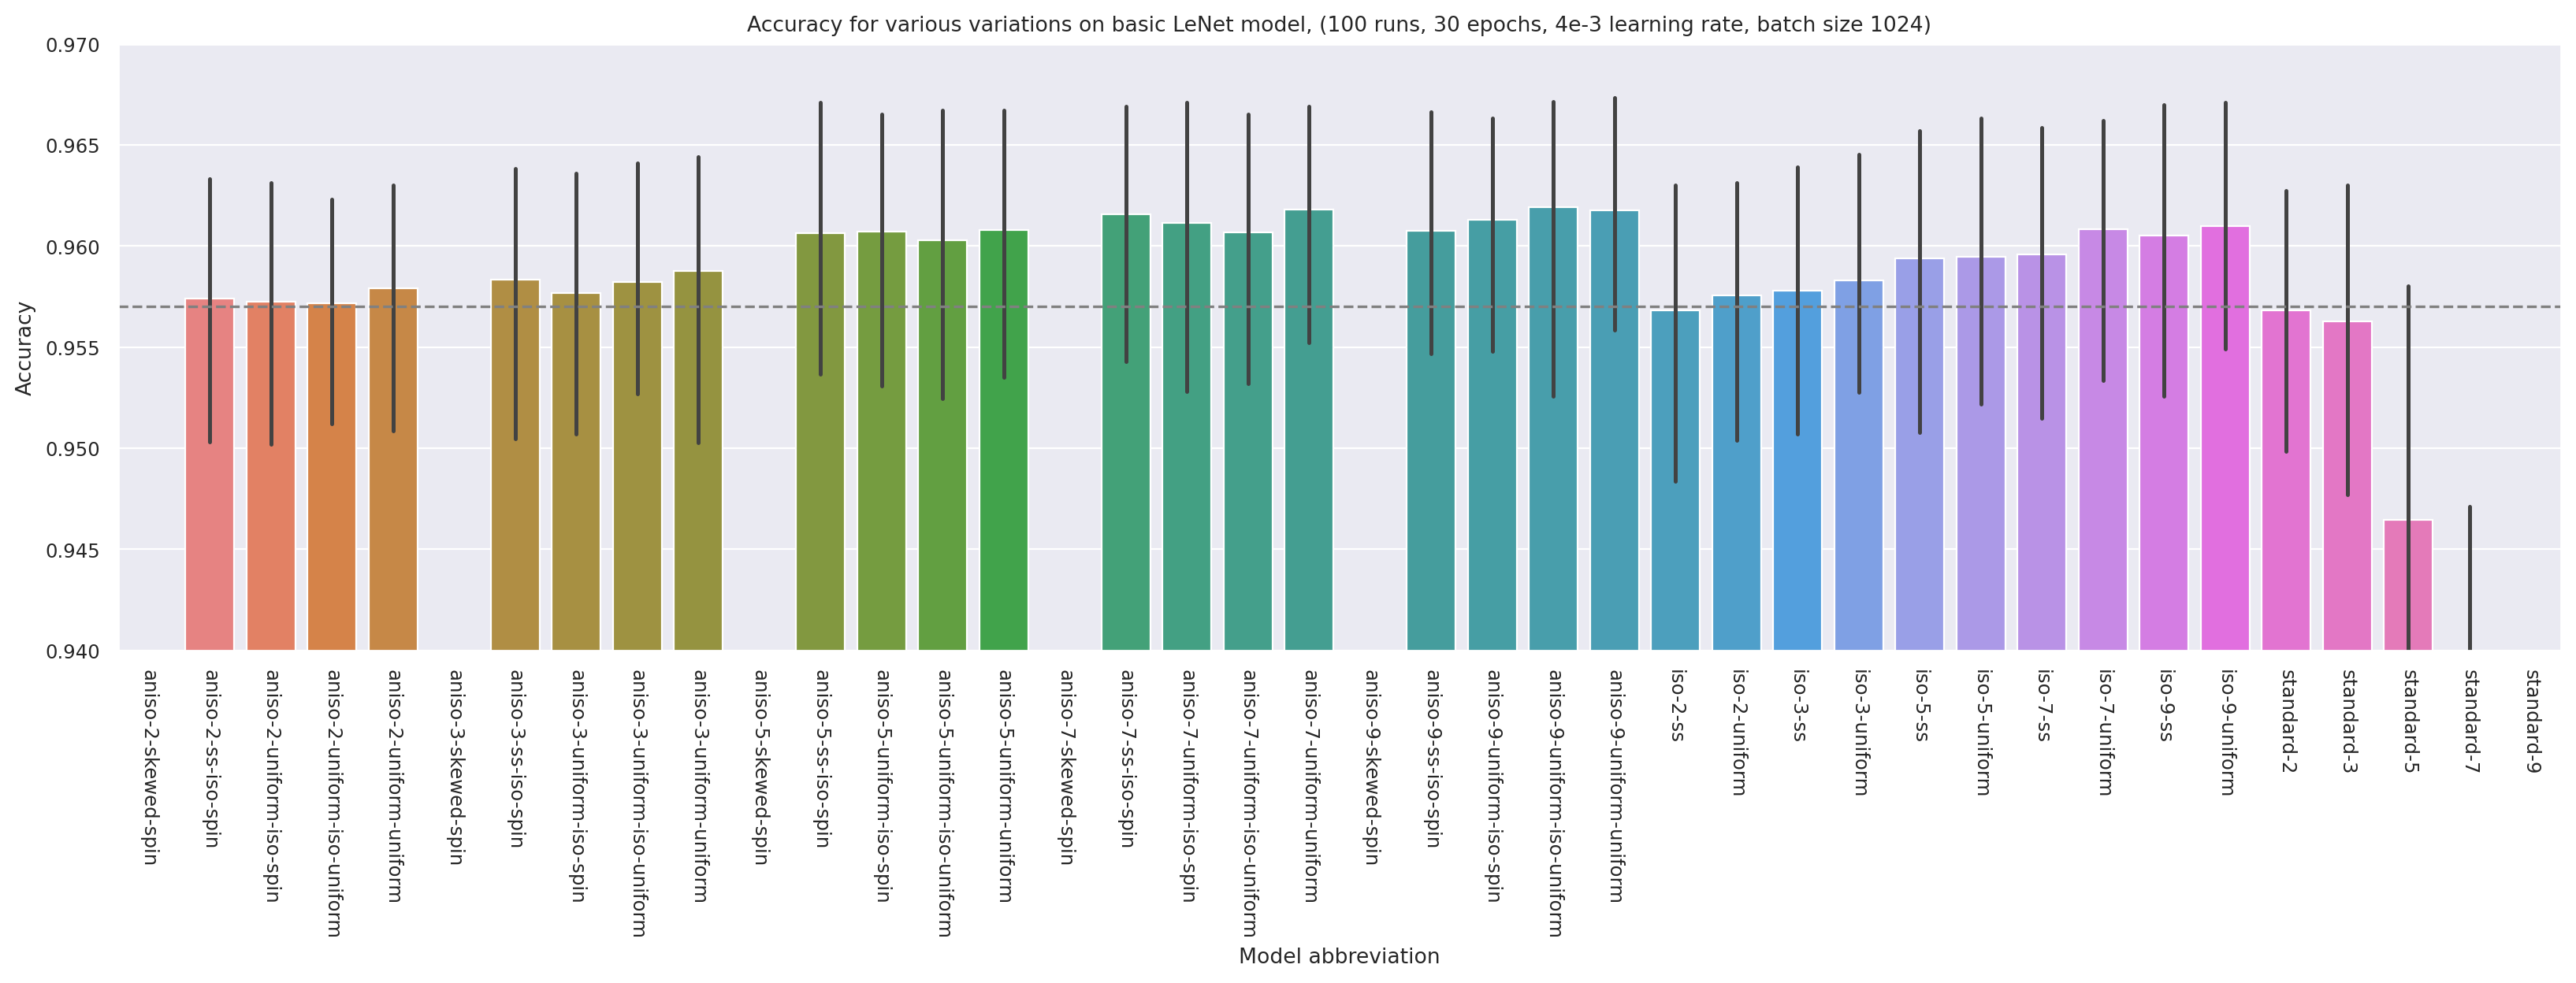

In [44]:
full_df = pl.concat((pl.scan_parquet(".data/thierry_long.pq"), pl.scan_parquet(".data/thierry_extend.pq")),
                    how='horizontal')
full_df = pl.scan_parquet(".data/long_kmnist.pq")
cols = sorted(full_df.collect_schema().names())
df = full_df.select(pl.col(cols).struct.field("acc").name.keep()).collect()
# sns.barplot({'a':[0.9471, 0.9617, 0.9567, 0.9646, 0.9506, 0.9596, 0.9531, 0.9553, 0.9578, 0.9642, 0.9532, 0.9458, 0.9513, 0.953, 0.9582, 0.9526, 0.9578, 0.9631, 0.96, 0.9557]}, errorbar=("pi", 90))
plt.figure(figsize=(20, 5), dpi=200)
sns.set_theme("paper", "darkgrid")
(sns.barplot(df.to_pandas(), errorbar=("pi", 90))
 .set(ylabel="Accuracy", xlabel="Model abbreviation",
      # title="Replication of Blankenstein's LeNet results on K-MNIST (100 runs, 5 epochs, 1e-3 learning rate, batch size 32)"
      title="Accuracy for various variations on basic LeNet model, (100 runs, 30 epochs, 4e-3 learning rate, batch size 1024)"
      ))
#
plt.xticks(rotation=-90)
plt.axhline(0.957, linestyle='dashed', color='gray')
plt.ylim(0.940, 0.97)

In [7]:
hs = {}

In [7]:
# importlib.reload(src.load_data)
# from src import load_data

# k_mnist = load_data.k_mnist()
km_tune = k_mnist.tuning_split()
print(k_mnist.y_train.dtype)

torch.int64


In [5]:
fashion_tune = load_data.fashion_mnist().tuning_split()
fashion_tune

Dataset(x_train=torch.Size([42000, 1, 28, 28]), x_test=torch.Size([18000, 1, 28, 28]), y_train=torch.Size([42000]), y_test=torch.Size([18000]))

In [9]:
cifar10_tune = cifar10.tuning_split()
cifar10_tune

Dataset(x_train=torch.Size([35000, 3, 32, 32]), x_test=torch.Size([15000, 3, 32, 32]), y_train=torch.Size([35000]), y_test=torch.Size([15000]))

In [10]:
cifar_hundred_tune = load_data.cifar100().tuning_split()
cifar_hundred_tune

Dataset(x_train=torch.Size([35000, 3, 32, 32]), x_test=torch.Size([15000, 3, 32, 32]), y_train=torch.Size([35000]), y_test=torch.Size([15000]))

In [ ]:
hist = HistoryCallback(cifar_hundred_tune)
lr = 0.004
CIFAR10CNN.fit_many(cifar_hundred_tune, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"}, count=7,
                    epoch_callback=hist, lr=lr, batch_size=1024, epochs=400)
hs_single = {lr: hist.result()}

In [8]:
import importlib

#
# importlib.reload(src.models.utils)
# importlib.reload(src.models.trainer)
# importlib.reload(src.models.simple_lenet)
# importlib.reload(src.models)
# importlib.reload(src.load_data)
# importlib.reload(src.kernels.quadratic)
# importlib.reload(src.kernels)
# from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS
# from src import load_data
torch.set_float32_matmul_precision("high")
hs = {}
res = {}
bar = tqdm.tqdm(np.logspace(np.log10(0.001), np.log10(0.005), num=10).tolist(), unit="trial")
model = LeNet
for lr in bar:
    bar.set_postfix(lr=lr)
    hist = HistoryCallback(fashion_tune)
    res[f'{lr=}'] = model.fit_many(fashion_tune, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"}, count=7,
                                   epoch_callback=hist, lr=lr, batch_size=1024, epochs=150)
    hs[lr] = hist.result()

pl.DataFrame({str(lr): vals[0] for lr, vals in hs.items()}).write_parquet(".data/tmp_tune_fashion.pq")

  0%|          | 0/10 [00:00<?, ?trial/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

In [26]:
pl.read_parquet(".data/tmp_tune.pq")

0.001,0.001291549665014884,0.0016681005372000592,0.0021544346900318843,0.0027825594022071257,0.003593813663804626,0.004641588833612777,0.005994842503189409,0.007742636826811269,0.01
struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4]
"{0.1389,0.0,0.339513,0.077811}","{0.1729,0.0,0.41353,0.120279}","{0.1549,0.0,0.427907,0.093744}","{0.1835,0.0,0.39126,0.107173}","{0.1835,0.0,0.357323,0.092197}","{0.1848,0.003945,0.396467,0.102379}","{0.1833,0.001974,0.375827,0.101505}","{0.1845,0.003914,0.431315,0.120612}","{0.1872,0.0059,0.441694,0.122478}","{0.1919,0.037418,0.420046,0.14571}"
"{0.1633,0.0,0.328063,0.105609}","{0.1551,0.0,0.320577,0.097096}","{0.2124,0.0,0.432127,0.148746}","{0.1935,0.001959,0.407659,0.135276}","{0.2365,0.01173,0.432544,0.179281}","{0.2314,0.014706,0.411713,0.170246}","{0.2642,0.009268,0.435835,0.242152}","{0.3039,0.003846,0.446287,0.261608}","{0.2855,0.028674,0.43197,0.244255}","{0.215,0.026743,0.411581,0.174714}"


In [42]:
# hs_old = hs

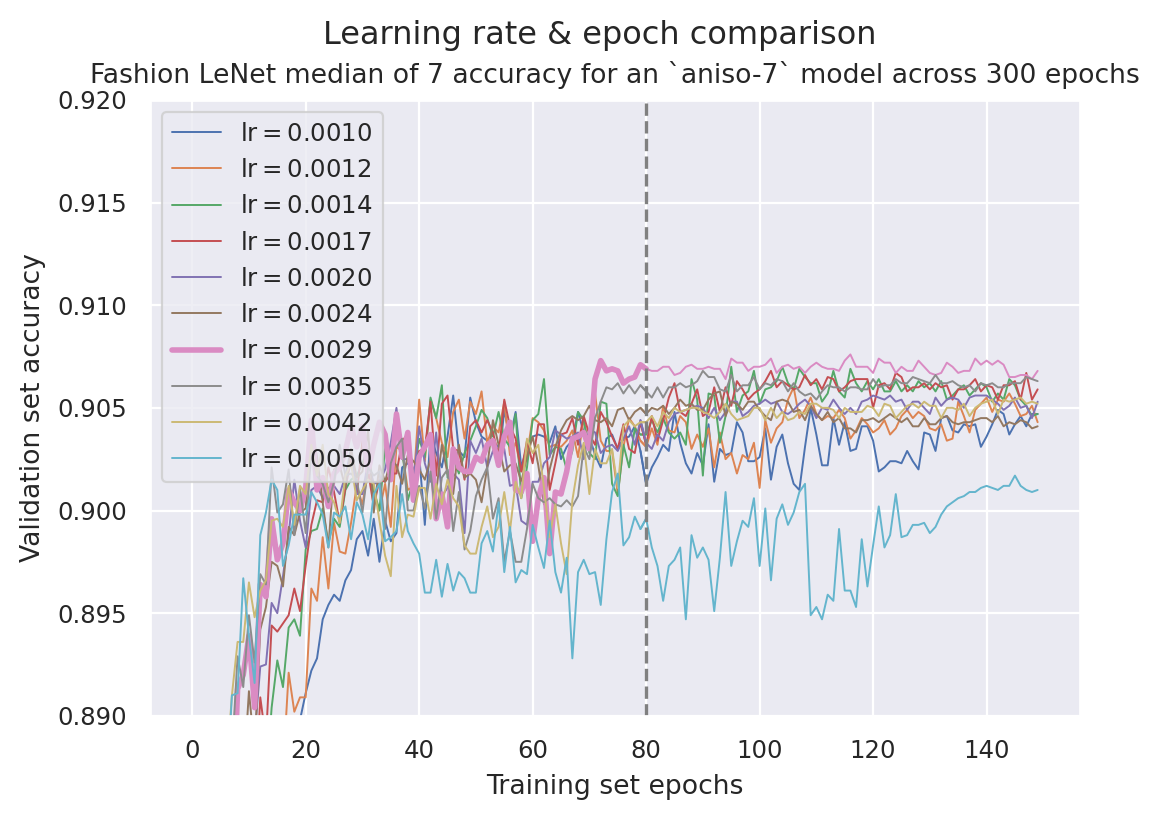

In [14]:
sns.set_theme("paper", "darkgrid")
plt.figure(dpi=200, figsize=(6, 4))
cutoff = 80
n_epochs = 150
for i, (lr, (vls, trns)) in enumerate(hs.items()):
    vals = np.median(vls["acc"].to_numpy().reshape(7, n_epochs), axis=0)
    color = plt.plot(range(cutoff + 1), vals[:cutoff + 1], label=f"lr$= {lr:.4f}$",
                     linewidth=0.7 if round(lr, 4) not in (0.0029,) else 2)[
        0].get_color()
    plt.plot(range(cutoff - 1, n_epochs), vals[cutoff - 1:], color=color, linewidth=0.7)
# plt.ylim(0.95, 0.99)
plt.ylim(0.89, 0.92)
# plt.ylim(0.79, 0.84)
plt.suptitle("Learning rate & epoch comparison")
plt.title("Fashion LeNet median of 7 accuracy for an `aniso-7` model across 300 epochs")
plt.xlabel("Training set epochs")
plt.ylabel("Validation set accuracy")
plt.axvline(cutoff, linestyle='dashed', color='gray')
# plt.text(cutoff + 3, 0.91, "Proposed cutoff", color='gray')
plt.xticks([cutoff], [f"{cutoff}"], minor=True)
plt.tick_params("x", colors="gray", which="minor")
plt.legend()

In [235]:
hist_m = history_callback(km_tune)
res['aniso-7-uiso'] = LeNet.fit_many(km_tune, pool_fn="aniso-7", init="uniform-iso", count=7, epoch_callback=hist_m,
                                     lr=0.004, batch_size=1024, epochs=100)

aniso-7:uniform-iso:   0%|          | 0/7 [00:00<?, ?run/s]

/home/peter/Thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/peter/Thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/peter/Thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [46]:
model = LeNet(1, 10, "aniso-7")
k0 = model.net[2].kernel()
model.fit(k_mnist, epochs=30, batch_size=1024, lr=0.004)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [54]:
k = model.net[2].kernel()
k.shape

torch.Size([20, 1, 7, 7])

In [64]:
model.evaluate(k_mnist, batch_size=10_000)

{'o': {'precision': 0.9670658682634731,
  'recall': 0.969,
  'f1-score': 0.968031968031968,
  'support': 1000.0},
 'ki': {'precision': 0.9694189602446484,
  'recall': 0.951,
  'f1-score': 0.9601211509338717,
  'support': 1000.0},
 'su': {'precision': 0.9630390143737166,
  'recall': 0.938,
  'f1-score': 0.950354609929078,
  'support': 1000.0},
 'tsu': {'precision': 0.9639024390243902,
  'recall': 0.988,
  'f1-score': 0.9758024691358025,
  'support': 1000.0},
 'na': {'precision': 0.9645030425963489,
  'recall': 0.951,
  'f1-score': 0.9577039274924471,
  'support': 1000.0},
 'ha': {'precision': 0.9765784114052953,
  'recall': 0.959,
  'f1-score': 0.9677093844601413,
  'support': 1000.0},
 'ma': {'precision': 0.9495635305528612,
  'recall': 0.979,
  'f1-score': 0.9640571147218119,
  'support': 1000.0},
 'ya': {'precision': 0.9730538922155688,
  'recall': 0.975,
  'f1-score': 0.974025974025974,
  'support': 1000.0},
 're': {'precision': 0.9635826771653543,
  'recall': 0.979,
  'f1-score': 0

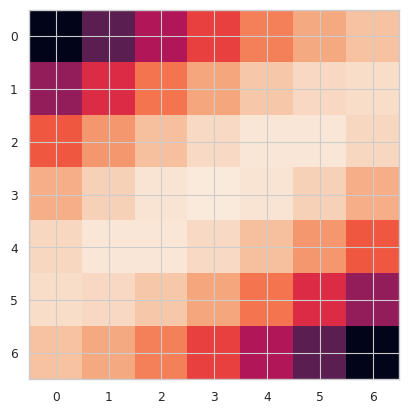

In [75]:
plt.imshow(k[8, 0].numpy(force=True))

In [76]:
torch.ones(3, device='cuda')

tensor([1., 1., 1.], device='cuda:0')

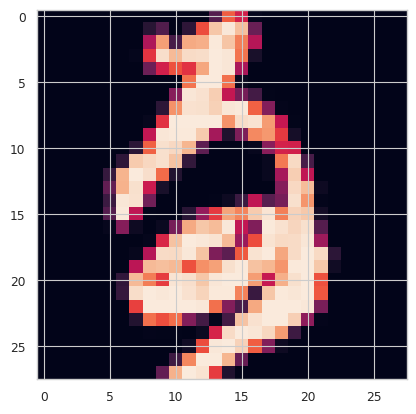

In [81]:
plt.imshow(k_mnist.x_train[4, 0])

In [ ]:
from pytorch_semifield_conv import